In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

# Task 1: Data Set

The following cell loads the first 10% of training and 1% of test examples of the 'genomics_ood' tensorflow dataset. The parameters in the tfds.load() function are shortly described, or more info please see the tensorflow overview on how to load datasets with tfds: https://www.tensorflow.org/datasets/overview

In [15]:
(train_data, test_data), ds_info = tfds.load('genomics_ood', 
                                   split=['train[:10%]', 'test[:1%]'], # Only load the first 10% of train and 1% of the test examples of the dataset as we only want 100.000 train and 1.000 test examples
                                   as_supervised=True, # This allows to call data, label for train and test data
                                   shuffle_files=True, # Shuffle
                                   try_gcs=True, # Load data from GCS bucket
                                   download=False, # Do not download the dataset locally
                                   with_info=True # This is only necessary if one wants to load info on the dataset (to variable ds_info)
                                   )

When loading the data set, one can choose to also get info on the dataset by setting with_info=True in tfds.load(). To take a look at the info, run the following cell.

In [16]:
# Print general info on dataset
print(ds_info)

tfds.core.DatasetInfo(
    name='genomics_ood',
    version=0.0.1,
    description='Bacteria identification based on genomic sequences holds the promise of early
detection of diseases, but requires a model that can output low confidence
predictions on out-of-distribution (OOD) genomic sequences from new bacteria
that were not present in the training data.

We introduce a genomics dataset for OOD detection that allows other researchers
to benchmark progress on this important problem. New bacterial classes are
gradually discovered over the years. Grouping classes by years is a natural way
to mimic the in-distribution and OOD examples.

The dataset contains genomic sequences sampled from 10 bacteria classes that
were discovered before the year 2011 as in-distribution classes, 60 bacteria
classes discovered between 2011-2016 as OOD for validation, and another 60
different bacteria classes discovered after 2016 as OOD for test, in total 130
bacteria classes. Note that training, validation, 

Also, we can take a look at the data. Because we set as_supervised=True when loading the data, we can iterate over either train or test data by calling 'for data, label in train:' and print the info we want. In the following cell, the first 5 training examples and labels will be printed.

In [17]:
# If one wants to take a look at the data
for i, (input, label) in enumerate(train_data): # This is possible because we set as_supervised=True when loading the dataset
  print('(' + str(i+1) + ')')

  # Data is a of type string:
  tf.print('Input:', input) # Use tf.print to only print string element (for print(data), the entire tensor content will be printed)

  # Labels are int ranging from 0-9
  tf.print('Label:', label, '\n')

  # This is to interrupt after 5 examples where shown
  if(i >= 4):
    break

(1)
Input: "AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT"
Label: 7 

(2)
Input: "CACAGCCGGCCGCTGACCTGCTGGCCATCGGAGCGCTGGCCGGCCTCGAGGATATTGGCCAGCAGCAGGTGGATGTCTCGGGCATAGCGCTCCCCCTGGTAGGTGATGCGAATGCTGCGGCCCTGGCGCTCGGTCAGGGCAAAACCCAGGGTCTGCTCCAGGCTCTTGATCTGGTGGCTGATGGCGCTGGGCGTCAGGTTCAGCTCATTGGCGGCCTCGGCGACACTGCCCAGGCGGGCCACCGCGTCCA"
Label: 5 

(3)
Input: "CGCCGGCACCGTTGCTGGCCAAAATCGCCGAGCGTCCGGATGCCGGCATGCATCGTGAATCGTCTTATCTGAAATGGCACTGGCGCGTTTGCCGGGAACTTCTCCAACGTCGGGAGCACGGGGCAACTCATGGCTAAACTCATCGTGGGCAACGTCGATAACGAAGCAATGATCGGGGACACGAAGCGTGCATCGCTTCCGCTTCGCCAGGTATCAGCGATTGCAGCAAGGCGCCTCGTCTGGCAGATGA"
Label: 1 

(4)
Input: "GCAGGTGCTGTTGGCCGGCACCAACCACCACATCCGCCTGCTGCAGAATGGCCAGCTGGCCTACACTGCCGAGCCGGTCAACGAAATCTATCGGCCTTCGATCGATGTGTTCTTCGAAAGCGTCGCGCGCTATTGGTCGGGCGATGCGGTGGGCGTGCTGCTC

The goal is to have the data one-hot-encoded. For this, we can first use the map function calling a function that encodes the letters to digits from 0-3, then constructs onehot encoding for each of the three numbers (0-3) and then applies this encoding to the previously 'translated' string.

In [18]:
# Mapping dictionary from letters to numbers
mapping = {'A': '0', 'C': '1', 'G': '2', 'T': '3'}

def one_hot_encoding(input, label):
  """
  Preprocess inputs and labels: Create onehot encoded input and labelling.
  """

  # Encode each letter to one number 0-3 according to 'mapping'-dictionary
  for key in mapping:
    input = tf.strings.regex_replace(input, key, mapping[key])
  
  # Split after each number
  split = tf.strings.bytes_split(input)

  # Encode input to Onehot encoding (numbers are strings atm, so convert those 
  # to ints before onehot encoding them)
  l = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot_input = tf.one_hot(l, 4)
  onehot_input = tf.reshape(onehot_input, (-1,))

  # Encode labels to onehot encoding
  onehot_label = tf.one_hot(label, 10)
  onehot_label = tf.reshape(onehot_label, (-1,10))

  return [onehot_input], onehot_label

In [19]:
# Preprocessing pipeline for train and test data
train_data_encoded = train_data.map(one_hot_encoding)
test_data_encoded = test_data.map(one_hot_encoding)

# Task 2: Model

In [20]:
class Model(Layer):

  def __init__(self):
    # Call super-class (of Model)
    super(Model, self).__init__()

    # Get activation functions
    SIGMOID = tf.keras.activations.sigmoid
    SOFTMAX = tf.keras.activations.softmax

    # Define fully connected (Dense) layers: two hidden layers with 256 units each, one output layer
    self.hidden_layer_1 = tf.keras.layers.Dense(256, activation=SIGMOID)
    self.hidden_layer_2 = tf.keras.layers.Dense(256, activation=SIGMOID)

    # Using softmax as output for network because we have 10 categories
    self.output_layer = tf.keras.layers.Dense(10, activation=SOFTMAX)

  
  @tf.function
  def call(self, x):
    # Define the forward step through two hidden layers to output layer
    x = self.hidden_layer_1(x)
    x = self.hidden_layer_2(x)
    x = self.output_layer(x)
    return x


# Task 3: Training

In [21]:
# Define parameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate)

# Initialize model
model = Model()

# Lists to store losses and accuracies for training and test steps
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

In [22]:
def train_step(model, input, target, loss_function, optimizer):
  """
  One training step on a given model with specified input, target, loss function 
  and optimizer.
  """
  with tf.GradientTape() as tape:
    # Get prediction for input
    prediction = model(input)

    # Calculate loss
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)

    # Calculate accuracy
    accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    accuracy = np.mean(accuracy)

  # Use optimizer function (training/ change weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, np.mean(accuracy)

def test(model, test_data, loss_function):
  """
  Tests model on test data to receive loss and accuracy on testing data.
  """

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    # Get prediction for each input from test data
    prediction = model(input)

    # Get loss and accuracy
    sample_test_loss = loss_function(target, prediction)

    # Compare positions of onehot encoded prediction and target - for each 
    # match, add 1, else 0. Then average over result
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy) 

    # Append current loss and accuracy
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  # Average over all losses and accuracies of the current epoch
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [23]:
for epoch in range(num_epochs):

  # Track epoch and time while code runs
  start = time.time()
  print('Start epoch ' + str(epoch+1) + '...')

  running_average_loss, running_average_accuracy = 0, 0

  # Iterate over training data
  for i, (input, target) in enumerate(train_data_encoded):

    # Calculate current loss and accuracy
    train_loss, train_accuracy = train_step(model, input, target, LOSS, OPTIMIZER)

    # Apply running average to current loss and accuracy
    running_average_loss = running_average_factor * running_average_loss + (1 - running_average_factor) * train_loss
    running_average_accuracy = running_average_factor * running_average_accuracy + (1 - running_average_factor) * train_accuracy
  
  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  # Calculate test loss and accuracies
  test_loss, test_accuracy = test(model, test_data_encoded, LOSS)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # Measure time required for each epoch
  print('... finished after ' + str(time.time() - start) + ' seconds')


Start epoch 1...
... finished after 543.5376720428467 seconds
Start epoch 2...
... finished after 548.7660810947418 seconds
Start epoch 3...
... finished after 553.4754402637482 seconds
Start epoch 4...
... finished after 545.5765941143036 seconds
Start epoch 5...
... finished after 550.8845825195312 seconds
Start epoch 6...
... finished after 549.2791266441345 seconds
Start epoch 7...
... finished after 548.1981384754181 seconds
Start epoch 8...
... finished after 517.4365527629852 seconds
Start epoch 9...
... finished after 540.6964292526245 seconds
Start epoch 10...
... finished after 546.6578307151794 seconds


# Task 4 Visualization

The following code is used to display training and testing losses and accuracies. There are two plots, one for training and one for testing where each plot contains the loss in red and accuracy in blue.

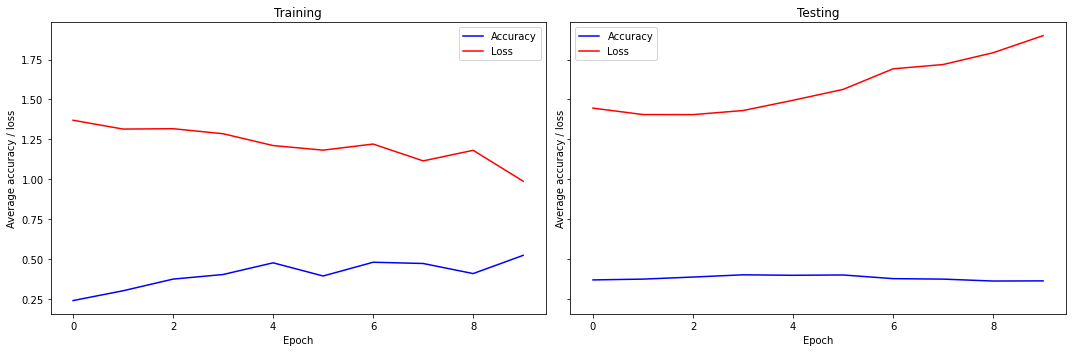

In [24]:
# Variables for plotting stored in lists
plot_values = [[train_accuracies, train_losses], [test_accuracies, test_losses]]
plot_titles = ['Training', 'Testing']

# Define plot (two horizontally aligned plots)
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)

# Create subplots for training and testing
for i, ax in enumerate(axes):

  # Respective title: 'Training', 'Testing'
  ax.set_title(plot_titles[i])

  # Get respective list for accuracies and losses
  ax.plot(plot_values[i][0], 'b', label='Accuracy')
  ax.plot(plot_values[i][1], 'r', label='Loss')
  
  ax.set(xlabel='Epoch', ylabel='Average accuracy / loss')
  ax.legend()

plt.tight_layout()
plt.show()